# Computation at hidden state:
\begin{align}
h_{t} = x_{t}w_{x} + h_{t-1}w_{a} + b
\end{align}

# Computation at output state:
\begin{align}
y_{t} = h_{t}w_{y} + b
\end{align}

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

%matplotlib inline

In [2]:
url = 'https://raw.githubusercontent.com/grvnair/rnn-implementation/main/ITC.csv'

df = pd.read_csv(url)

In [3]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,ITC,EQ,656.00,694.00,708.50,675.0,708.50,708.50,701.81,562715,3.949174e+13,NaN,NaN,NaN
1,2000-01-04,ITC,EQ,708.50,714.00,729.00,694.3,710.65,712.35,714.16,712637,5.089379e+13,NaN,NaN,NaN
2,2000-01-05,ITC,EQ,712.35,716.25,758.90,660.0,731.00,726.20,732.43,1382149,1.012325e+14,NaN,NaN,NaN
3,2000-01-06,ITC,EQ,726.20,741.00,784.30,741.0,784.30,784.30,776.63,721618,5.604266e+13,NaN,NaN,NaN
4,2000-01-07,ITC,EQ,784.30,832.40,847.05,824.0,847.05,847.05,841.25,231209,1.945046e+13,NaN,NaN,NaN


In [4]:
df.columns

Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')

In [5]:
# To keep things simple, we will only work with the 'Date' and 'close' column

df = df.drop(columns=['Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'])

In [6]:
df = df.rename({'Close' : 'Price'}, axis = 1)

In [7]:
df.head()

,Date,Price
0,2000-01-03,708.50
1,2000-01-04,712.35
2,2000-01-05,726.20
3,2000-01-06,784.30
4,2000-01-07,847.05


In [8]:
df.shape

(5306, 2)

In [9]:
df.dtypes

Date      object
Price    float64
dtype: object

In [10]:
df.isnull().sum()

Date     0
Price    0
dtype: int64

Text(0, 0.5, 'Price')

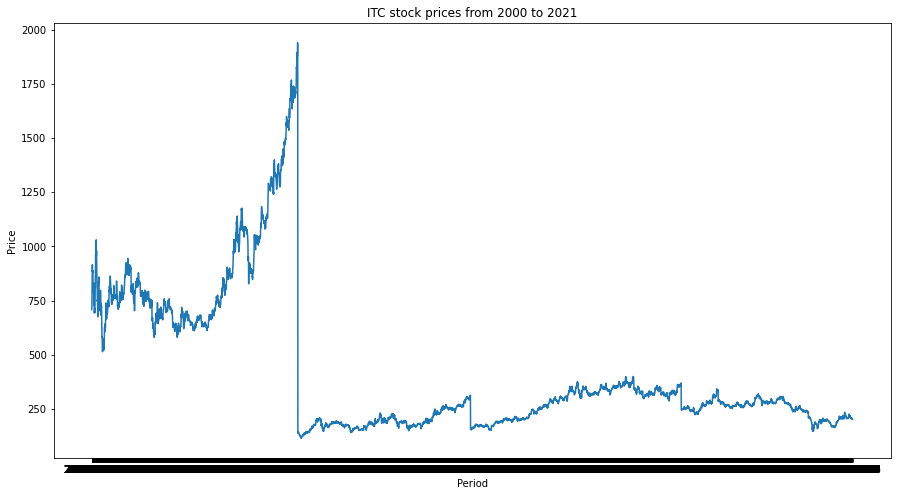

In [11]:
plt.figure(figsize=[15,8])
plt.title("ITC stock prices from 2000 to 2021")
plt.plot(df['Date'], df['Price'])
plt.xlabel('Period')
plt.ylabel('Price')

In [12]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[['Price']])
len(scaled_df)

5306

In [13]:
# While working with time series, we do not need a random train and test dataset. Hence, we will split it manually

test_size = 500
train_size = len(scaled_df) - test_size
print(train_size)

4806


In [14]:
training_prices = scaled_df[0:train_size,:]
test_prices = scaled_df[train_size:,:]

print(training_prices.shape, test_prices.shape)

(4806, 1) (500, 1)


In [23]:
# We will need to modify the dataset for giving input to the RNN model

def rnn_input(data, lookback = 1):

  x_df, y_df = [], []
  for i in range(len(data) - lookback - 1):
    # Data points from this point, looking backwards upto lookback
    a = data[i:(i + lookback), 0]

    x_df.append(a)
    y_df.append(data[i + lookback, 0])

  return np.array(x_df), np.array(y_df)

# Lookback for 100 days
lookback = 50

# Creating the X and y for training
train_x, train_y = rnn_input(training_prices, lookback)

train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))

print(train_x.shape, train_y.shape)

(4755, 1, 50) (4755,)


# Building the RNN Model

In [24]:
model = Sequential()

model.add(SimpleRNN(32, input_shape=(1, lookback)))
model.add(Dense(1))

model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                2656      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(train_x, train_y, epochs = 5, batch_size = 1)

Epoch 1/5
4755/4755 [==============================] - 10s 2ms/step - loss: 0.0457 - mse: 0.0457
Epoch 2/5
4755/4755 [==============================] - 9s 2ms/step - loss: 0.0302 - mse: 0.0302
Epoch 3/5
4755/4755 [==============================] - 9s 2ms/step - loss: 0.0347 - mse: 0.0347
Epoch 4/5
4755/4755 [==============================] - 9s 2ms/step - loss: 0.0262 - mse: 0.0262
Epoch 5/5
4755/4755 [==============================] - 9s 2ms/step - loss: 0.0303 - mse: 0.0303


# Testing the Model

In [26]:
# Test set preparation

test_x, test_y = rnn_input(test_prices, lookback)

test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

print(test_x.shape, test_y.shape)

(449, 1, 50) (449,)


In [27]:
predictions = model.predict(test_x)

15/15 [==============================] - 0s 2ms/step


In [28]:
# As we scaled the values initially, we will need to inverse it to get the correct output

predictions = scaler.inverse_transform(predictions)

# Visualizing Predictions 

In [29]:
orig = df[['Price']].loc[len(scaled_df) - len(predictions):]
orig.reset_index(drop = True, inplace = True)

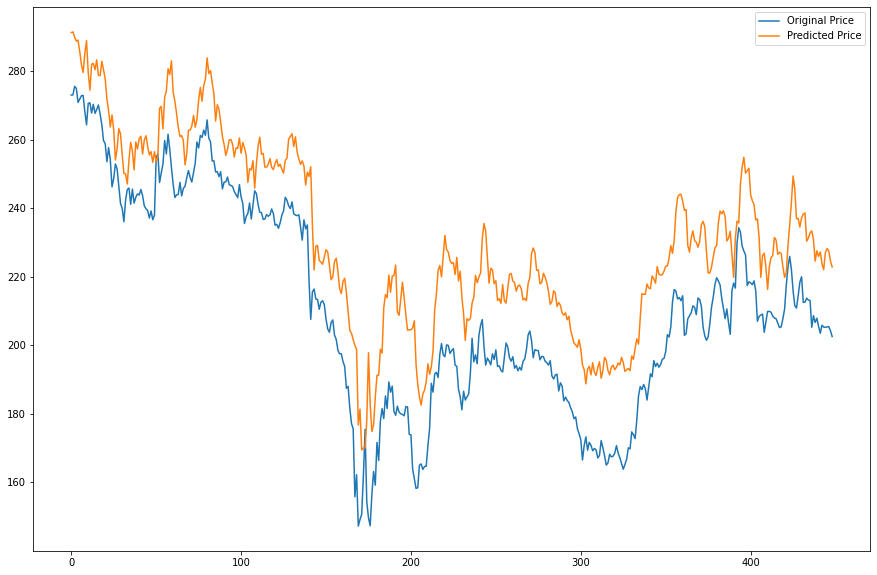

In [30]:
plt.figure(figsize=[15,10])
plt.plot(orig, label = 'Original Price')
plt.plot(predictions, label = 'Predicted Price')
plt.legend()